In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal
from keras import backend as K
#import data - 30 years from 1993/10/01 to 2023/10/01
url = "https://raw.githubusercontent.com/WithAnOrchid0513/VolData/main/SPY_data.csv"
df = pd.read_csv(url, index_col = 'Date', parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-10-01,45.87500,46.21875,45.81250,46.15625,26.676367,22700
1993-10-04,46.21875,46.21875,46.09375,46.21875,26.712498,1038500
1993-10-05,46.31250,46.31250,46.00000,46.15625,26.676367,436500
1993-10-06,46.18750,46.37500,46.12500,46.12500,26.658302,209200
1993-10-07,46.18750,46.18750,45.96875,46.00000,26.586082,59400


In [ ]:
#stationary check
def adf(x):
  res = adfuller(x)
  print("Test-Statistic:", res[0])
  print("P-Value:", res[1])
  if res[1] < 0.05:
    print("Stationary")
  else:
    print("Non-Stationary")

In [ ]:
#close price
adf(df.Close)

Test-Statistic: 0.7956196331833991
P-Value: 0.9915651306637264
Non-Stationary


In [ ]:
#calculate log returns
df['log_returns'] = np.log(df.Close/df.Close.shift(1))
df.dropna(inplace=True)

In [ ]:
adf(df['log_returns'])

Test-Statistic: -16.17790643720345
P-Value: 4.296732064719343e-29
Stationary


# LSTM

In [ ]:
WINDOW_SIZE = 22
#convert data to 22-day np array for LSTM prediction
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        from_idx = x_series.index[i-lookback_window+1]
        to_idx = x_series.index[i]
        a = x_series[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
#calculate realized volatility
def realized_volatility_daily(series_log_return):
    return np.sqrt(np.sum(series_log_return**2)/(WINDOW_SIZE-1))

In [ ]:
n_future = 10
# get current volatility
df['vol_current'] = df.log_returns.rolling(window=WINDOW_SIZE)\
                                   .apply(realized_volatility_daily)

# get future volatility
df['vol_future'] = df.log_returns.shift(n_future).rolling(window=WINDOW_SIZE)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.dropna(inplace=True)

In [ ]:
#Base
#train test split, 27 years training, 3 years testing
test_size = 756
split_time_1 = 0
split_time_2 = len(df) - test_size
split_time_3 = 7521
train_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:split_time_3]

#Financial Crisis period
# split_time_1 = 800
# split_time_2 = split_time_1 + 2520
# split_time_3 = split_time_2 + 756

# train_idx = df.index[split_time_1:split_time_2]
# test_idx = df.index[split_time_2:split_time_3]

#COVID1 10yrs training
# split_time_1 = 4100
# split_time_2 = split_time_1 + 2520
# split_time_3 = split_time_2 + 756

# train_idx = df.index[split_time_1:split_time_2]
# test_idx = df.index[split_time_2:split_time_3]

#COVID2 15 yrs training
# split_time_1 = 2840
# split_time_2 = split_time_1 + 3780
# split_time_3 = split_time_2 + 756

# train_idx = df.index[split_time_1:split_time_2]
# test_idx = df.index[split_time_2:split_time_3]

In [ ]:
print(f'Training \tFrom: {train_idx[0]} \tto {train_idx[-1]} \t{len(train_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 1993-11-16 00:00:00 	to 2020-09-28 00:00:00 	6765 days
Test 		From: 2020-09-29 00:00:00 	to 2023-09-29 00:00:00 	756 days


In [ ]:
#split train test
y_train = df.vol_future[train_idx]
y_test = df.vol_future[test_idx]
x_train = df.vol_current[train_idx]
x_test = df.vol_current[test_idx]

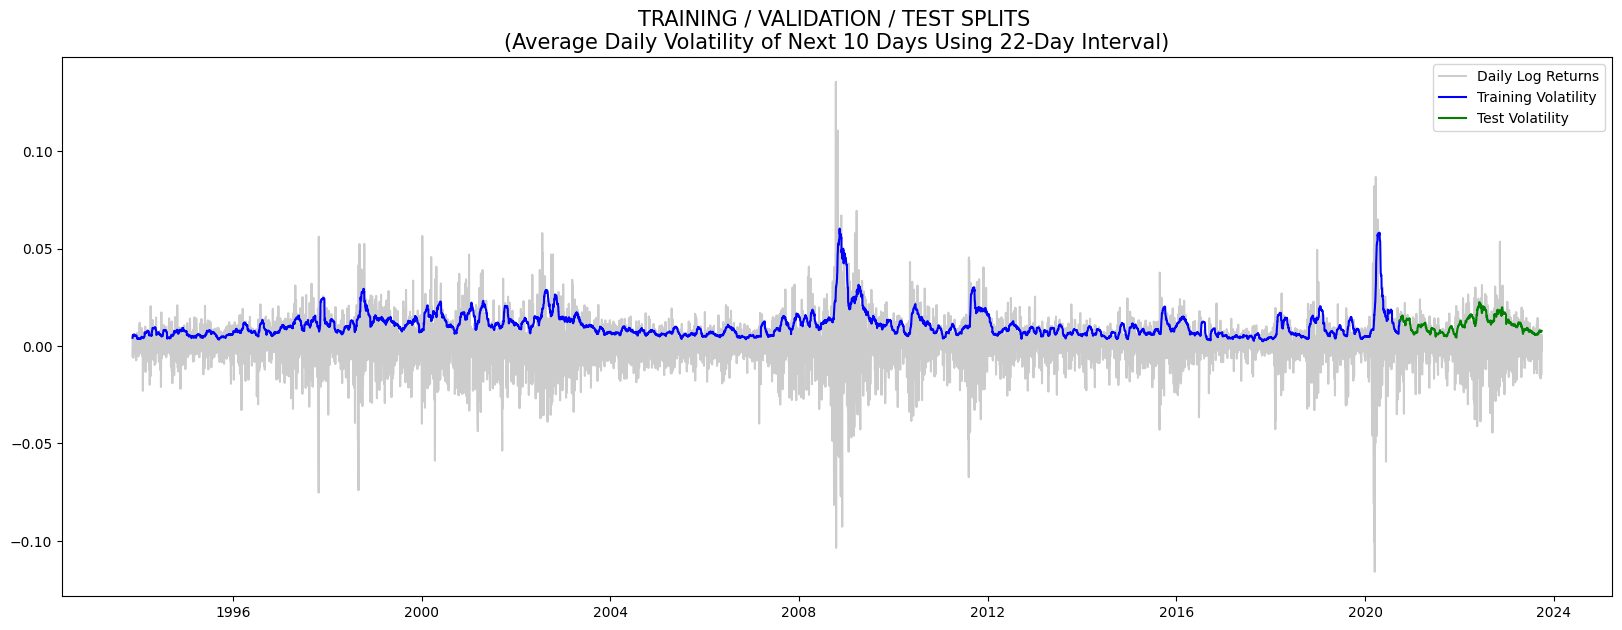

In [ ]:
#plot of log_return and volatility
plt.figure(figsize=(20,7))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(y_train, color='blue', label='Training Volatility')
plt.plot(y_test, color='green', label='Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS \n(Average Daily Volatility of Next {n_future} Days Using {WINDOW_SIZE}-Day Interval)', fontsize=15)
plt.legend()
plt.show();

In [ ]:
#the forecasting function
n_past = 22

def val_forecast(model):
    forecast = []
    idx = df.index

    for i in range(len(test_idx)):
        #get the data at the previous n_past (22) time steps
        from_idx = idx[split_time_2 + i - n_past + 1]
        to_idx = idx[split_time_2 + i]
        #make prediction
        pred = model.predict(df.vol_current[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=test_idx)
    return preds

In [ ]:
#record model error
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

#define Root Mean Squared Percentage Error function
def RMSPE(y_true, y_pred):
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output


#define Root Mean Squared Error function
def RMSE(y_true, y_pred):
    output = np.sqrt(mse(y_true, y_pred))
    return output

#rmspe for tensorflow
def rmspe(y_true, y_pred):
    output = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))
    return output

#plotting model predictions vs. target values
def viz_model(y_true, y_pred, model_name):
    plt.figure(figsize=(20,7))
    plt.plot(y_true, color='blue', label='Real Volatility')
    plt.plot(y_pred, color='orange', lw=3, label=f'Forecasted Volatility')

    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend(loc='best');
    plt.title(f'{model_name} \non Test Data', fontsize=15)
    plt.legend(loc='best');

In [ ]:
#initialize
tf.keras.backend.clear_session()

batch_size = 64

#reshape the data
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_test, mat_y_test = windowed_dataset(x_test, y_test, n_past)

#LSTM model
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(1)
])

lstm.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='loss')

#stop the training if not improving within 20 epochs
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_res = lstm.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_test, mat_y_test),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
106/106 [==============================] - 22s 67ms/step - loss: 1.1960e-05 - rmspe: 0.2699 - val_loss: 7.7501e-07 - val_rmspe: 0.0862
Epoch 2/200
  3/106 [..............................] - ETA: 3s - loss: 1.1194e-06 - rmspe: 0.1068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


106/106 [==============================] - 4s 34ms/step - loss: 1.2896e-06 - rmspe: 0.1192 - val_loss: 6.7908e-07 - val_rmspe: 0.0753
Epoch 3/200
106/106 [==============================] - 4s 34ms/step - loss: 1.1764e-06 - rmspe: 0.1151 - val_loss: 5.3777e-07 - val_rmspe: 0.0734
Epoch 4/200
106/106 [==============================] - 5s 44ms/step - loss: 1.1235e-06 - rmspe: 0.1139 - val_loss: 9.4942e-07 - val_rmspe: 0.0975
Epoch 5/200
106/106 [==============================] - 5s 43ms/step - loss: 9.5169e-07 - rmspe: 0.1014 - val_loss: 1.0962e-06 - val_rmspe: 0.0971
Epoch 6/200
106/106 [==============================] - 4s 34ms/step - loss: 8.5311e-07 - rmspe: 0.0966 - val_loss: 8.3734e-07 - val_rmspe: 0.0911
Epoch 7/200
106/106 [==============================] - 4s 33ms/step - loss: 7.7823e-07 - rmspe: 0.0927 - val_loss: 3.6579e-07 - val_rmspe: 0.0579
Epoch 8/200
106/106 [==============================] - 5s 51ms/step - loss: 9.7624e-07 - rmspe: 0.1056 - val_loss: 8.9711e-07 - val_rmsp

In [ ]:
#predict
lstm_preds = val_forecast(lstm)

1/1 [==============================] - 0s 25ms/step


In [ ]:
#annualize
lstm_preds = lstm_preds * np.sqrt(252)
y_test = y_test * np.sqrt(252)

#store result
log_perf(y_test, lstm_preds, 'LSTM')

,Model,Validation RMSPE,Validation RMSE
0,LSTM,0.03575,0.006081


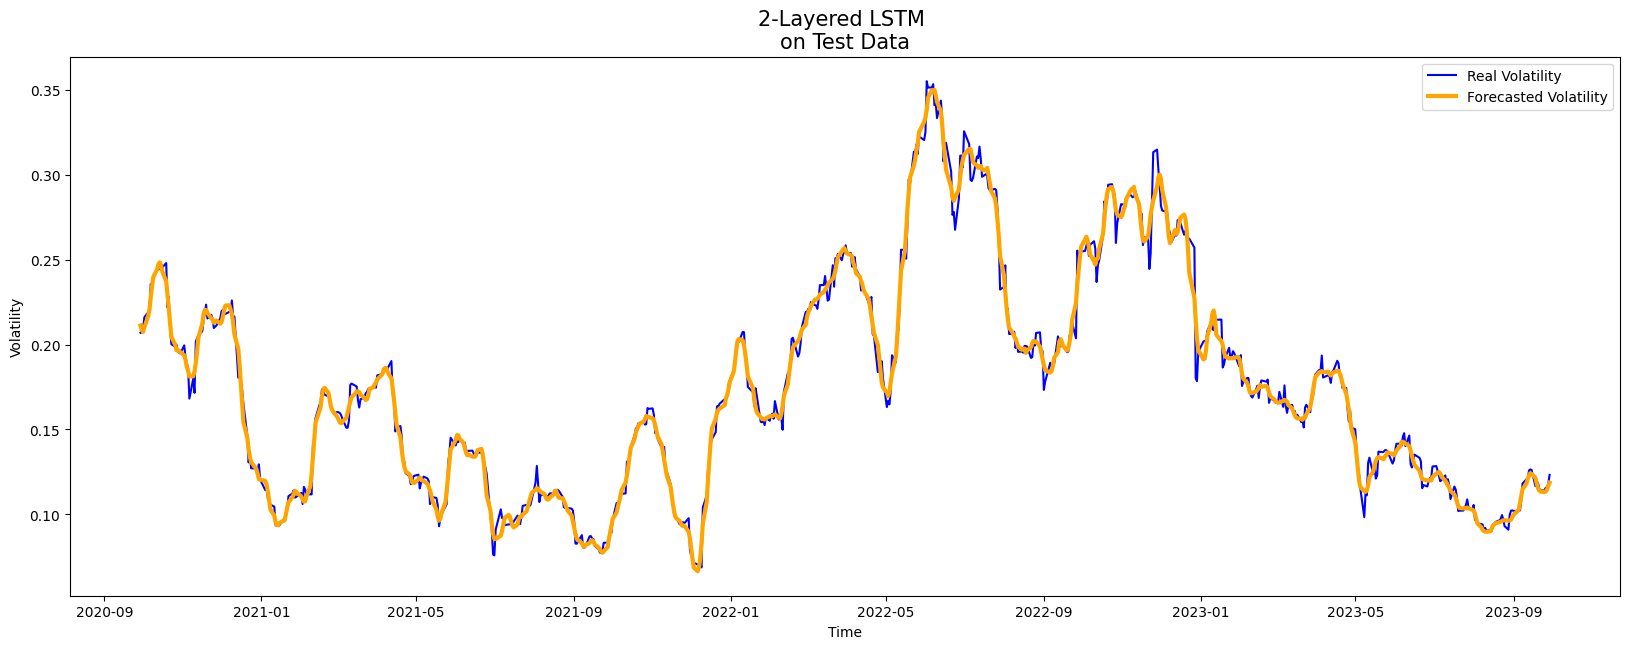

In [ ]:
#make graph
viz_model(y_test, lstm_preds, "2-Layered LSTM")

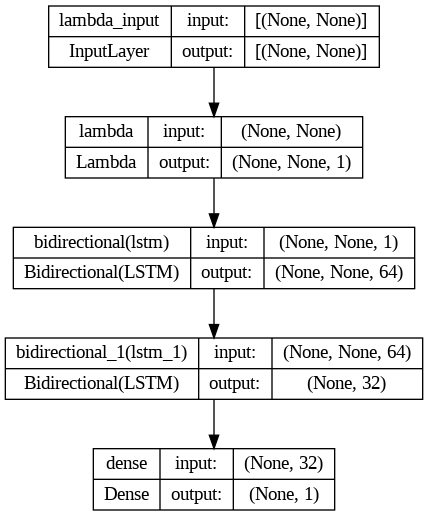

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(lstm, show_shapes=True)

# Implied Volatility

In [ ]:
#load vix as implied volatility data
vix_url = "https://raw.githubusercontent.com/WithAnOrchid0513/VolData/main/VIX_data.csv"
vix = pd.read_csv(vix_url, index_col = 'DATE', parse_dates = True)
vix.tail()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2023-09-25,17.25,18.41,16.79,16.90
2023-09-26,18.03,19.50,17.17,18.94
2023-09-27,18.29,19.71,18.03,18.22
2023-09-28,18.22,18.77,17.06,17.34
2023-09-29,16.87,17.74,15.83,17.52


In [ ]:
iv = vix.CLOSE[test_idx] * 0.01
iv

Date
2020-09-29    0.2627
2020-09-30    0.2637
2020-10-01    0.2670
2020-10-02    0.2763
2020-10-05    0.2796
               ...  
2023-09-25    0.1690
2023-09-26    0.1894
2023-09-27    0.1822
2023-09-28    0.1734
2023-09-29    0.1752
Name: CLOSE, Length: 756, dtype: float64

In [ ]:
#store result
log_perf(y_test, iv, 'Implied Volatility')

,Model,Validation RMSPE,Validation RMSE
0,LSTM,0.03575,0.006081
1,Implied Volatility,0.60142,0.070133


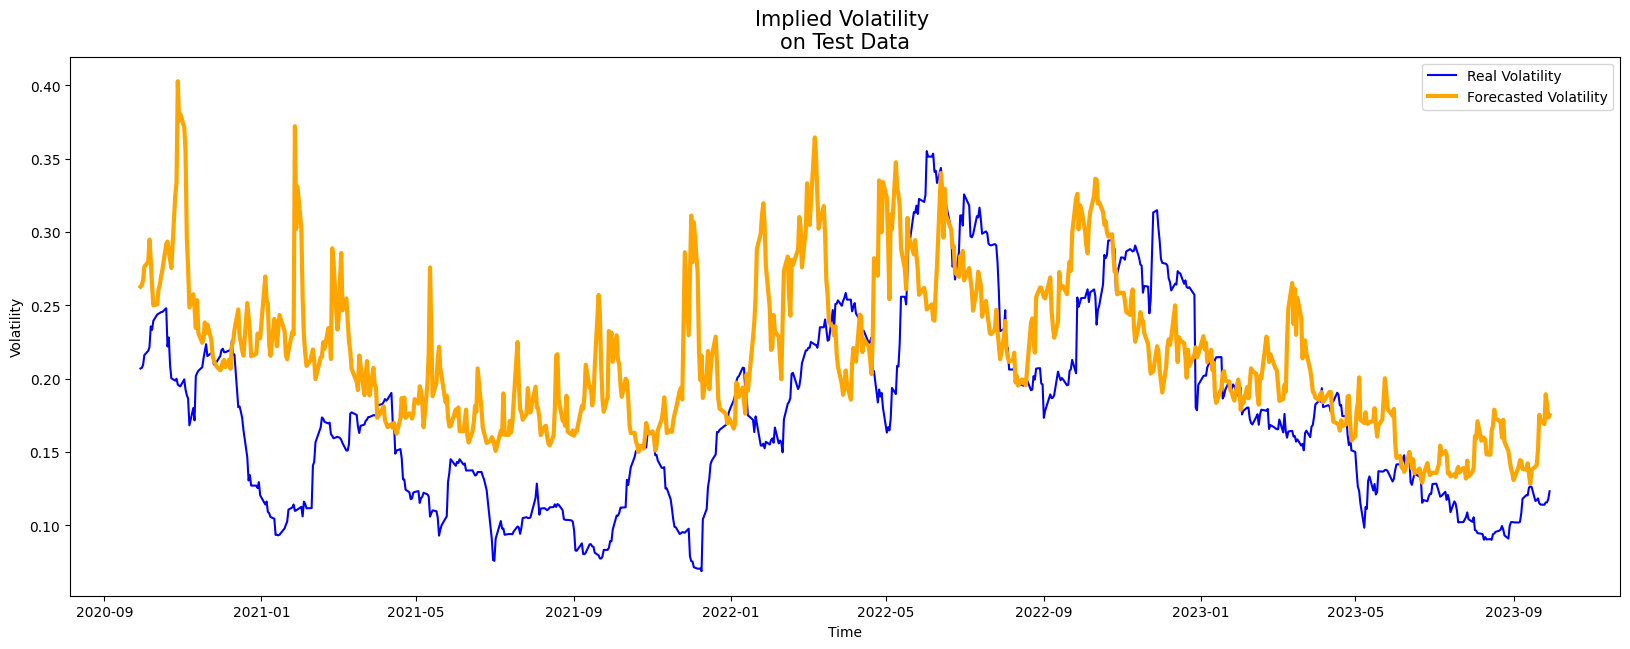

In [ ]:
#make graph
viz_model(y_test, iv, "Implied Volatility")

# GARCH

In [ ]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 12.3 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

In [ ]:
len(test_idx)+n_future

766

In [ ]:
#rolling forecast
rolling_forecasts = []
idx = df.index

# iterate over each time step in the validation set
for i in range(len(test_idx)+n_future):

    if i < n_future:
      idx = train_idx[-i-1]
    else:
      idx = test_idx[i-n_future]
    #scale the data for GARCH convergance issue
    train = df.log_returns[:idx] * 100

    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    #make predictions
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    rolling_forecasts.append(pred)

gm_preds = pd.Series(rolling_forecasts, index=df.index[split_time_2-n_future:split_time_3])
#annualize and unscale the data
gm_preds = gm_preds * np.sqrt(252) / 100

In [ ]:
gm_preds = gm_preds.shift(n_future)
gm_preds = gm_preds.dropna()

In [ ]:
#store result
log_perf(y_test, gm_preds, 'GARCH(1,1)')

,Model,Validation RMSPE,Validation RMSE
0,LSTM,0.035750,0.006081
1,Implied Volatility,0.601420,0.070133
2,"GARCH(1,1)",0.158073,0.025077


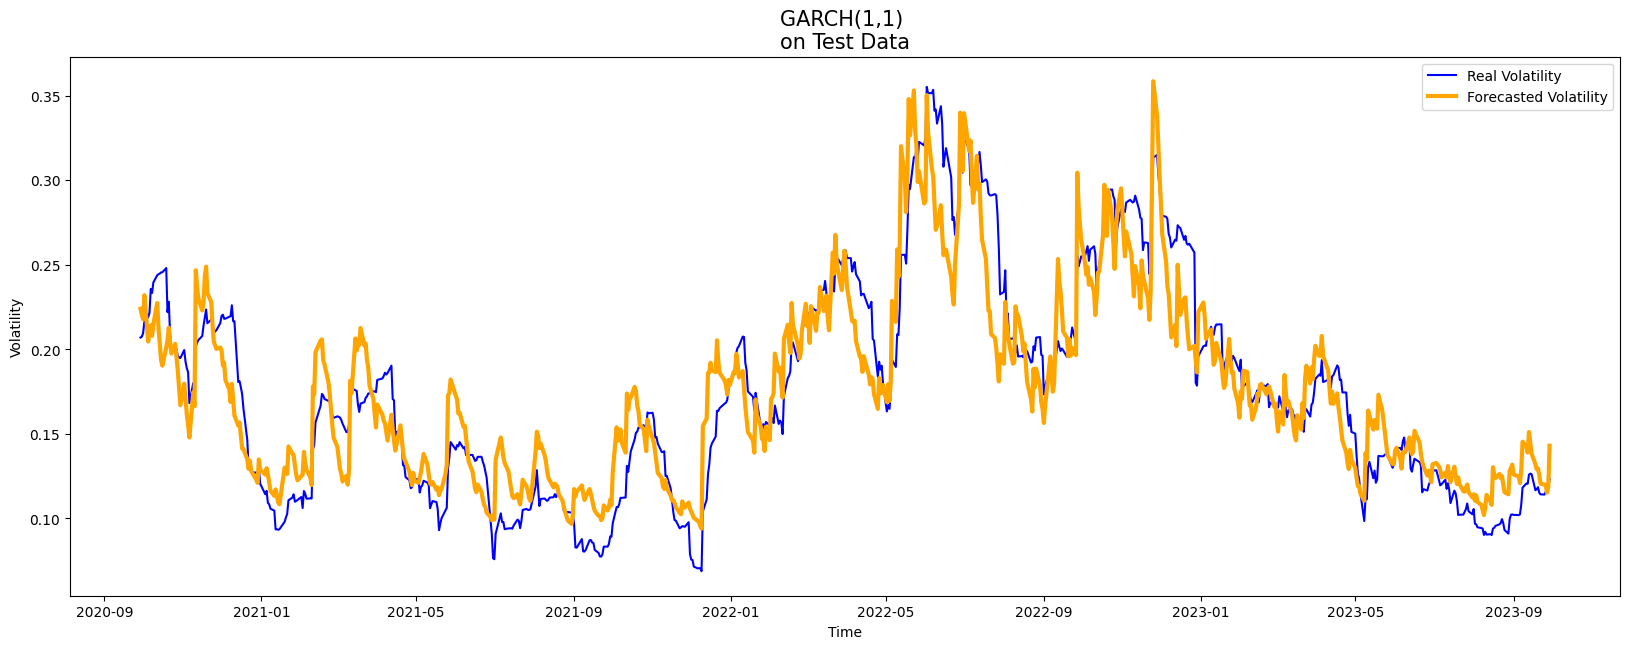

In [ ]:
#make graph
viz_model(y_test, gm_preds, 'GARCH(1,1)')

# Transformer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
#reshape the data
transformer_x_train, transformer_y_train = windowed_dataset(x_train, y_train, n_past)
transformer_x_test, transformer_y_test = windowed_dataset(x_test, y_test, n_past)

transformer_x_train = transformer_x_train.reshape((transformer_x_train.shape[0], transformer_x_train.shape[1], 1))
transformer_x_test = transformer_x_test.reshape((transformer_x_test.shape[0], transformer_x_test.shape[1], 1))

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    #Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = transformer_x_train.shape[1:]

transformer_model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

transformer_model.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])
transformer_model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]

transformer_res = transformer_model.fit(
    transformer_x_train,
    transformer_y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    callbacks=callbacks,
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 22, 1)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 22, 1)                2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 22, 1)                14337     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [ ]:
t_preds = val_forecast(transformer_model)

1/1 [==============================] - 0s 61ms/step


In [ ]:
t_preds = t_preds * np.sqrt(252)

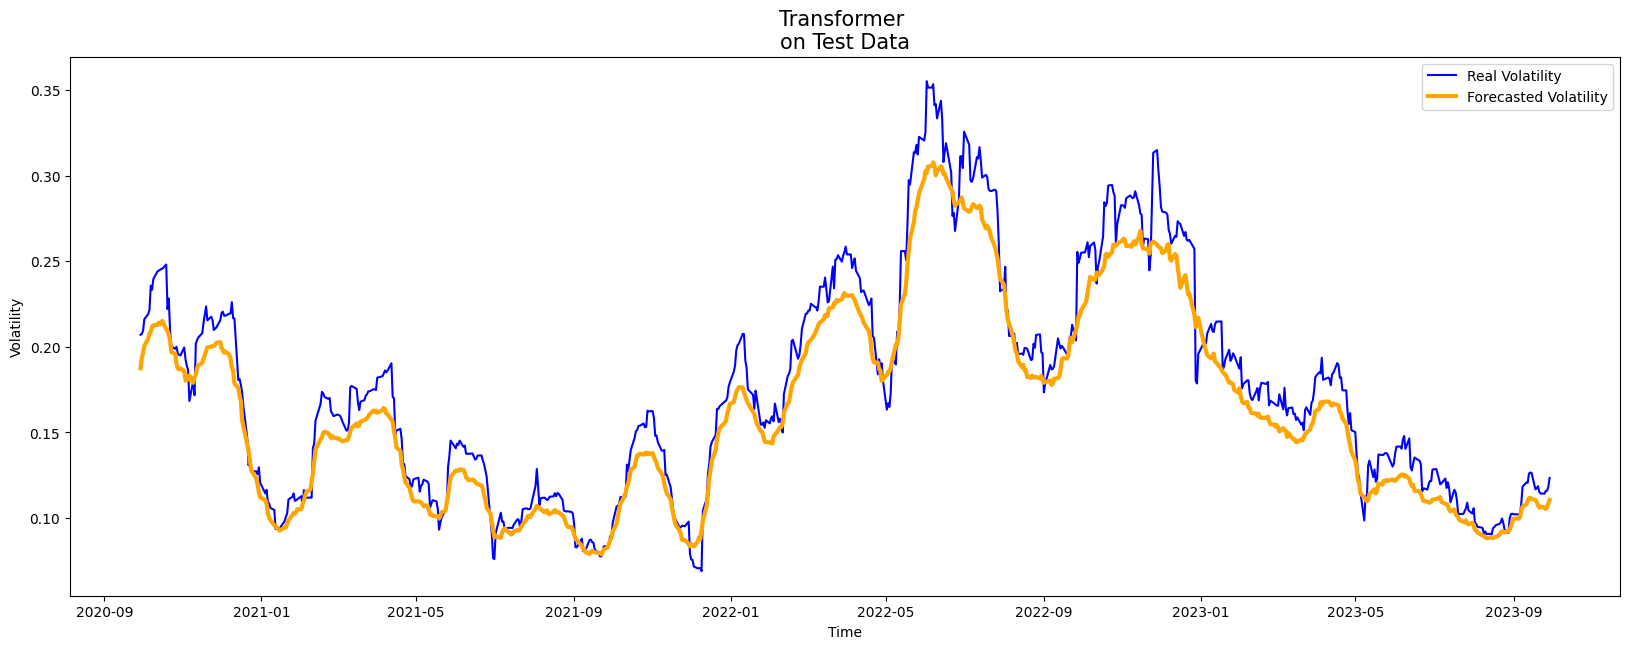

In [ ]:
#make graph
viz_model(y_test, t_preds, "Transformer")

In [ ]:
#store result
log_perf(y_test, t_preds, 'Transformer')

,Model,Validation RMSPE,Validation RMSE
0,LSTM,0.035750,0.006081
1,Implied Volatility,0.601420,0.070133
2,"GARCH(1,1)",0.158073,0.025077
3,Transformer,0.088603,0.017068


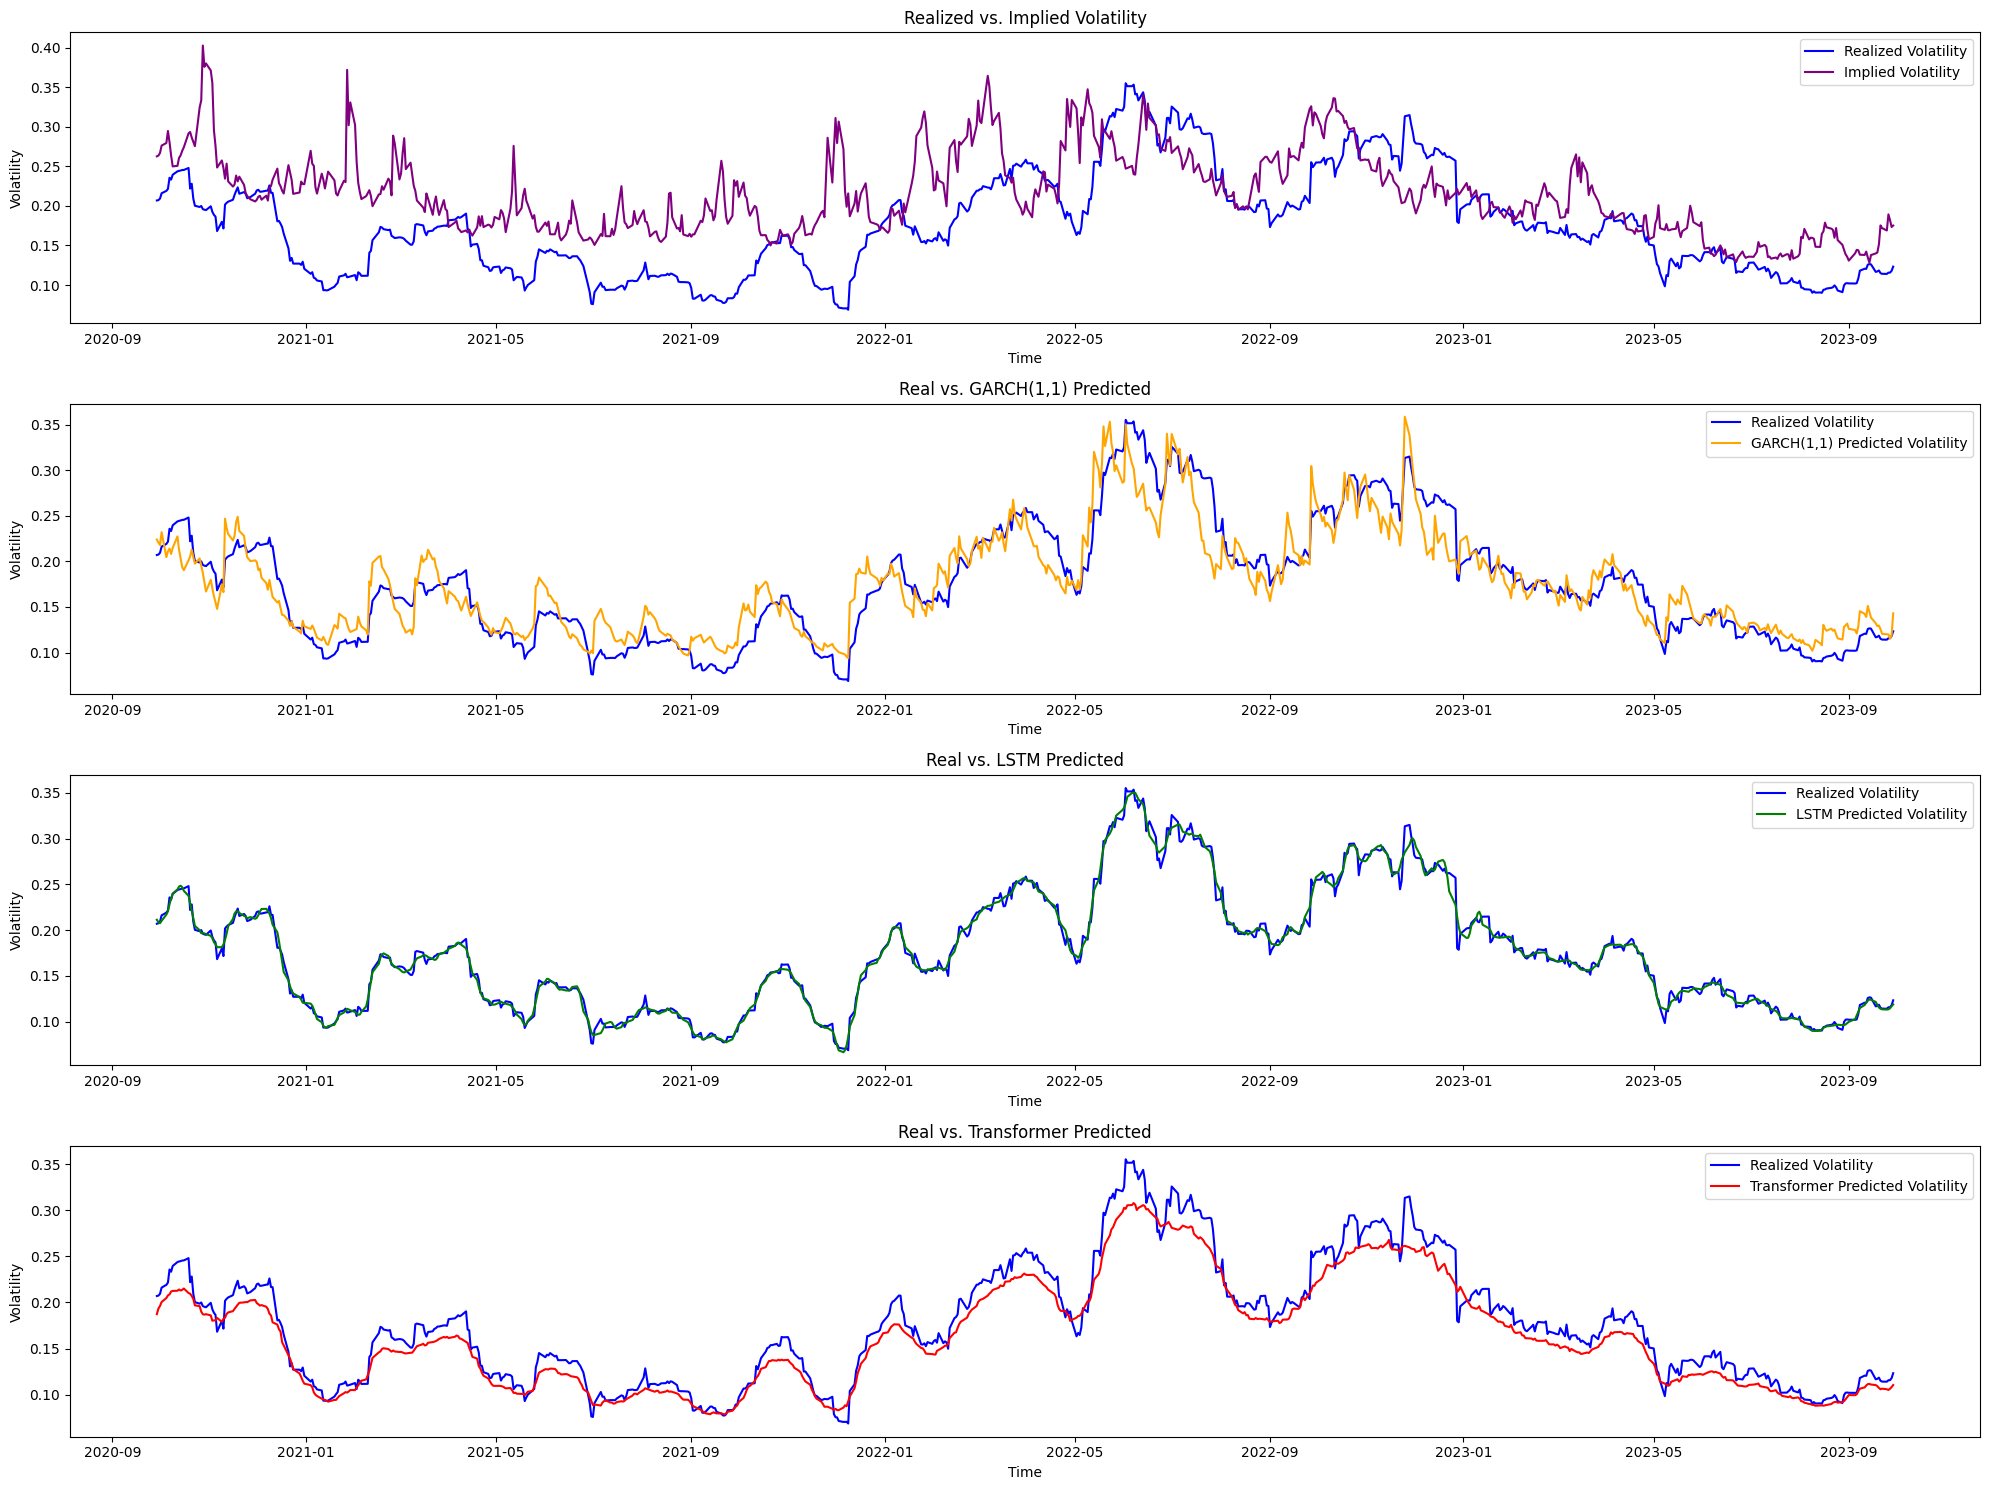

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))

#labels
labels = ['Realized Volatility', 'Implied Volatility', 'GARCH(1,1) Predicted Volatility', 'LSTM Predicted Volatility', 'Transformer Predicted Volatility']

#First plot: Real vs Implied Volatility
axs[0].plot(y_test, color='blue', label=labels[0])
axs[0].plot(iv, color='purple', label=labels[1])
axs[0].set_title('Realized vs. Implied Volatility')
axs[0].legend()

#Second plot: Real vs GARCH(1,1) Forecasted Volatility
axs[1].plot(y_test, color='blue', label=labels[0])
axs[1].plot(gm_preds, color='orange', label=labels[2])
axs[1].set_title('Real vs. GARCH(1,1) Predicted')
axs[1].legend()

#Third plot: Real vs LSTM Forecasted Volatility
axs[2].plot(y_test, color='blue', label=labels[0])
axs[2].plot(lstm_preds, color='green', label=labels[3])
axs[2].set_title('Real vs. LSTM Predicted')
axs[2].legend()

#Fourth plot: Real vs Transformer Forecasted Volatility
axs[3].plot(y_test, color='blue', label=labels[0])
axs[3].plot(t_preds, color='red', label=labels[4])
axs[3].set_title('Real vs. Transformer Predicted')
axs[3].legend()

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Volatility')

plt.tight_layout()

plt.show()

In [ ]:
lstm_train_loss = lstm_res.history['rmspe']
lstm_train_loss = np.log(lstm_train_loss)
transformer_train_loss = transformer_res.history['rmspe']
transformer_train_loss = np.log(transformer_train_loss)

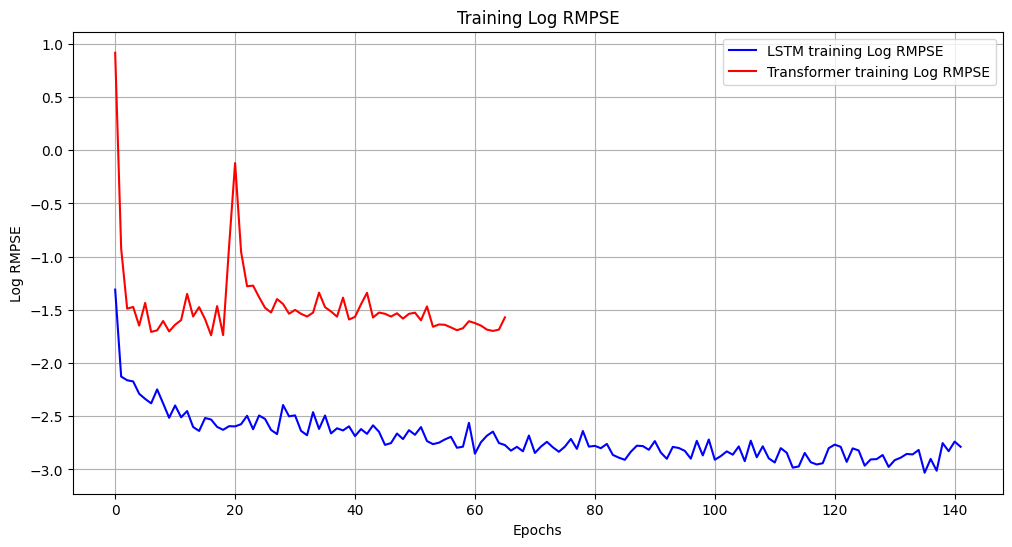

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(lstm_train_loss, label='LSTM training Log RMPSE', color='blue')
plt.plot(transformer_train_loss, label='Transformer training Log RMPSE', color='red')

plt.title('Training Log RMPSE')
plt.xlabel('Epochs')
plt.ylabel('Log RMPSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# y_test_df = y_test.to_frame(name='y_test')
# lstm_preds_df = lstm_preds.to_frame(name='lstm_preds')
# iv_df = iv.to_frame(name='iv')
# t_preds_df = t_preds.to_frame(name='t_preds')
# gm_preds_df = gm_preds.to_frame(name='gm_preds')

# merged_df = pd.concat([y_test_df, lstm_preds_df, iv_df, t_preds_df, gm_preds_df], axis=1)

In [ ]:
#merged_df

,y_test,lstm_preds,iv,t_preds,gm_preds
Date,,,,,
2020-09-29,0.206932,0.211262,0.2627,0.187295,0.223890
2020-09-30,0.207390,0.208549,0.2637,0.193397,0.220621
2020-10-01,0.209347,0.207478,0.2670,0.196162,0.217822
2020-10-02,0.216058,0.210074,0.2763,0.200436,0.231971
2020-10-05,0.219033,0.216892,0.2796,0.204722,0.204599
...,...,...,...,...,...
2023-09-25,0.114087,0.113169,0.1690,0.105871,0.119965
2023-09-26,0.115660,0.113447,0.1894,0.105158,0.119828
2023-09-27,0.115713,0.114550,0.1822,0.106432,0.115251


In [ ]:
#merged_df.to_csv('merged_dataframe.csv')